
# Restaurant Sales — Advanced Business Analysis

**Author:** Anand Krishna  
**Dataset:** Kaggle — Restaurant Sales Data (Rohit Grewal)  
**Style:** Question → Method → Code → Results → Takeaway (inspired by Christine Jiang's analyses)

---

### Executive KPIs
We will compute and visualize:
- Monthly/seasonal revenue trend and **product mix shift**
- **ABC/Pareto** contribution by product & by city
- **Channel mix** (Online vs In-store) and **Payment methods**
- **Manager performance** benchmarking
- **City growth** and price/volume differences
- **Basket & cross-sell** signals (co-occurrence + lift)
- **Price–Quantity** sensitivity (per product) with simple linear fits
- **Anomaly detection** on daily revenue (z-scores)
- **Distribution** of order values (deciles) and basket sizes
- **Weekend effect** vs weekdays


## 0. Setup & Load

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

%matplotlib inline

CSV_PATH = (r"C:\Users\DELL\Downloads\9. Sales-Data-Analysis.csv")
df = pd.read_csv(CSV_PATH)

# Clean and enrich
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y", errors='coerce')
df['month'] = df['Date'].dt.to_period('M')
df['year']  = df['Date'].dt.year
df['dow']   = df['Date'].dt.day_name()
df['Revenue'] = df['Price'] * df['Quantity']

print("Rows:", len(df))
print("Date range:", df['Date'].min(), "→", df['Date'].max())
print("Cities:", sorted(df['City'].unique().tolist()))
print("Managers:", sorted(df['Manager'].dropna().unique().tolist()))
print("Products:", sorted(df['Product'].unique().tolist()))


Rows: 254
Date range: 2022-11-07 00:00:00 → 2022-12-29 00:00:00
Cities: ['Berlin', 'Lisbon', 'London', 'Madrid', 'Paris']
Managers: ['       Pablo Perez', '       Remy Monet', 'Joao    Silva', 'Joao Silva', 'Pablo    Perez', 'Pablo   Perez', 'Pablo  Perez', 'Pablo Perez', 'Remy     Monet', 'Remy    Monet', 'Remy Monet', 'Tom      Jackson', 'Tom Jackson', 'Walter Muller']
Products: ['Beverages', 'Burgers', 'Chicken Sandwiches', 'Fries', 'Sides & Other']



## 1. Monthly / Seasonal Trend & Product Mix
**Method:** Revenue aggregated by month; stacked product mix share to see shifts.


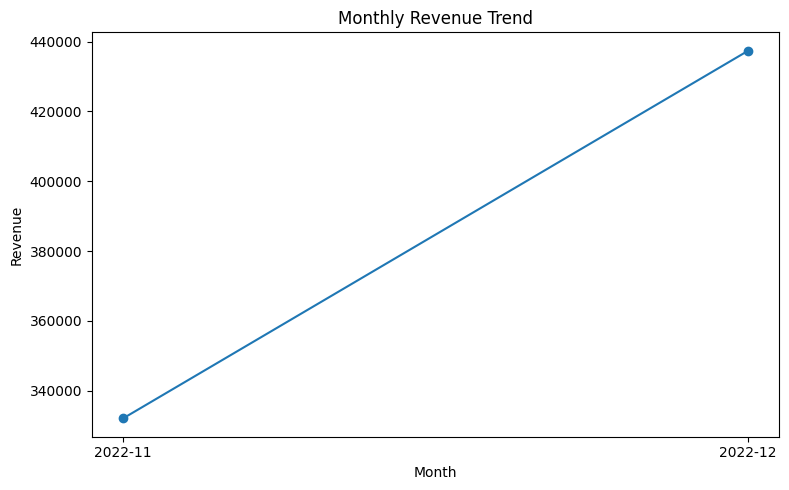

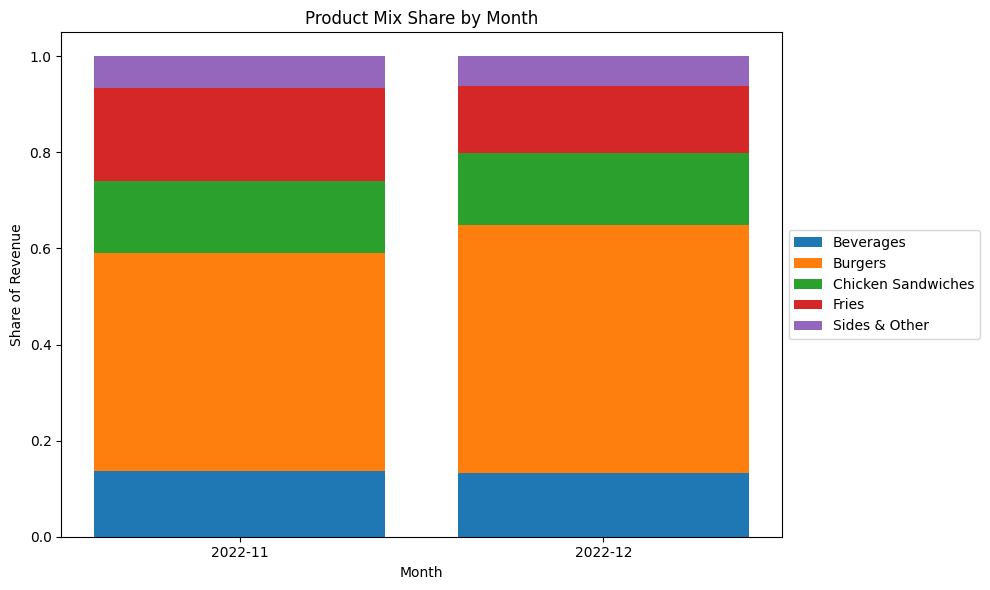

(Product  Beverages      Burgers  Chicken Sandwiches       Fries  Sides & Other
 month                                                                         
 2022-11  45600.097  150399.7788          49840.4295  64274.4411      21999.912
 2022-12  57600.166  226600.0281          64801.2655  61399.8492      26999.892,
 Product  Beverages   Burgers  Chicken Sandwiches     Fries  Sides & Other
 month                                                                    
 2022-11   0.137302  0.452855            0.150070  0.193531       0.066242
 2022-12   0.131687  0.518060            0.148151  0.140374       0.061728)

In [2]:

monthly_rev = df.groupby('month')['Revenue'].sum().sort_index()

plt.figure(figsize=(8,5))
plt.plot(monthly_rev.index.astype(str), monthly_rev.values, marker='o')
plt.title("Monthly Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.tight_layout(); plt.show()

# Product mix share per month
mix = df.pivot_table(index='month', columns='Product', values='Revenue', aggfunc='sum').fillna(0)
mix_share = mix.div(mix.sum(axis=1), axis=0)

# Stacked area for product mix share
plt.figure(figsize=(10,6))
x = np.arange(len(mix_share.index))
bottom = np.zeros(len(mix_share))
for prod in mix_share.columns:
    plt.bar(mix_share.index.astype(str), mix_share[prod].values, bottom=bottom, label=prod)
    bottom += mix_share[prod].values
plt.title("Product Mix Share by Month")
plt.xlabel("Month"); plt.ylabel("Share of Revenue")
plt.legend(loc='center left', bbox_to_anchor=(1,0.5)); plt.tight_layout(); plt.show()

mix, mix_share



## 2. ABC / Pareto Contribution
**Method:** Rank by revenue, compute cumulative contribution; mark A/B/C classes at ~80/95/100%.


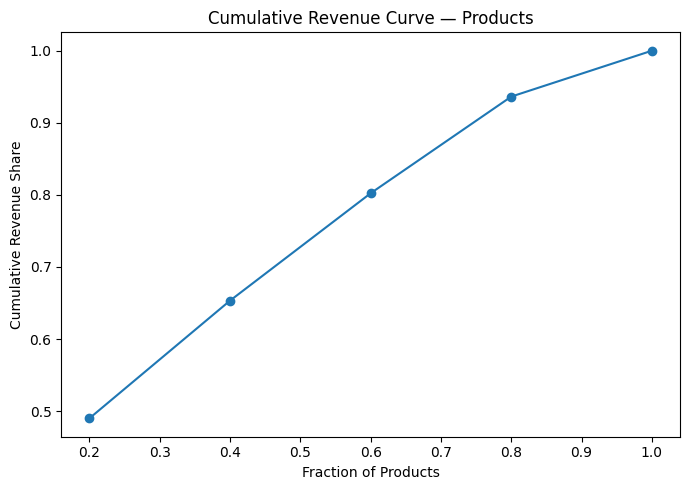

(                        Revenue     Share  CumShare Class
 Product                                                  
 Burgers             376999.8069  0.489918  0.489918     A
 Fries               125674.2903  0.163316  0.653234     A
 Chicken Sandwiches  114641.6950  0.148979  0.802213     B
 Beverages           103200.2630  0.134111  0.936324     B
 Sides & Other        48999.8040  0.063676  1.000000     C,
             Revenue     Share  CumShare Class
 City                                         
 Lisbon  241714.1157  0.314112  0.314112     A
 London  211201.0406  0.274460  0.588572     A
 Madrid  136200.2665  0.176995  0.765566     A
 Berlin  100600.1313  0.130732  0.896298     B
 Paris    79800.3051  0.103702  1.000000     C)

In [3]:

def pareto_table(series, name='Entity'):
    t = series.sort_values(ascending=False).to_frame('Revenue')
    t['Share'] = t['Revenue'] / t['Revenue'].sum()
    t['CumShare'] = t['Share'].cumsum()
    def label(c):
        if c <= 0.80: return 'A'
        elif c <= 0.95: return 'B'
        else: return 'C'
    t['Class'] = t['CumShare'].apply(label)
    t.index.name = name
    return t

prod_pareto = pareto_table(df.groupby('Product')['Revenue'].sum(), 'Product')
city_pareto = pareto_table(df.groupby('City')['Revenue'].sum(), 'City')

# Plot Lorenz-like cumulative for products
p = prod_pareto.reset_index()
p['Rank'] = np.arange(1, len(p)+1)
plt.figure(figsize=(7,5))
plt.plot(p['Rank']/len(p), p['CumShare'], marker='o')
plt.title("Cumulative Revenue Curve — Products")
plt.xlabel("Fraction of Products"); plt.ylabel("Cumulative Revenue Share")
plt.tight_layout(); plt.show()

prod_pareto, city_pareto



## 3. Channel & Payment Mix
**Method:** Compare revenue by `Purchase Type` and `Payment Method`, and cross-tab.


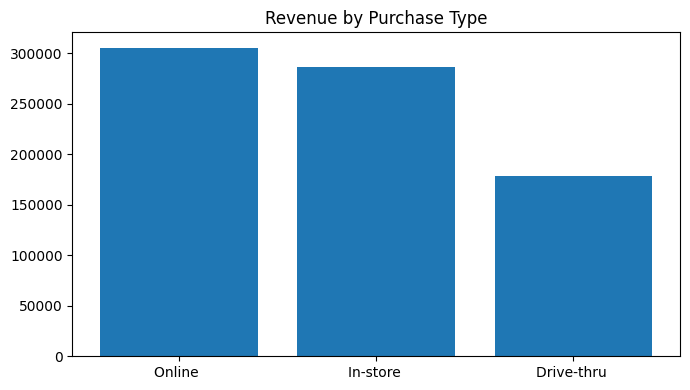

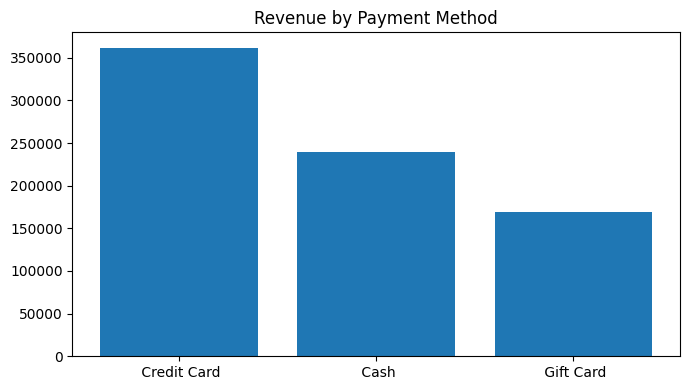

Payment Method,Cash,Credit Card,Gift Card
Purchase Type,,,
Drive-thru,52600.1675,90600.2545,35400.0510
In-store,144799.9193,137914.0726,3000.0075
Online,41800.1487,133200.6994,130200.5387


In [4]:

chan = df.groupby('Purchase Type')['Revenue'].sum().sort_values(ascending=False)
pay  = df.groupby('Payment Method')['Revenue'].sum().sort_values(ascending=False)

plt.figure(figsize=(7,4)); plt.bar(chan.index, chan.values); plt.title("Revenue by Purchase Type"); plt.tight_layout(); plt.show()
plt.figure(figsize=(7,4)); plt.bar(pay.index, pay.values); plt.title("Revenue by Payment Method"); plt.tight_layout(); plt.show()

# Cross-tab
cross = df.pivot_table(index='Purchase Type', columns='Payment Method', values='Revenue', aggfunc='sum').fillna(0)
cross



## 4. Manager Performance Benchmarking
**Method:** For each Manager, compute total revenue, average order value (AOV), mix of channels.


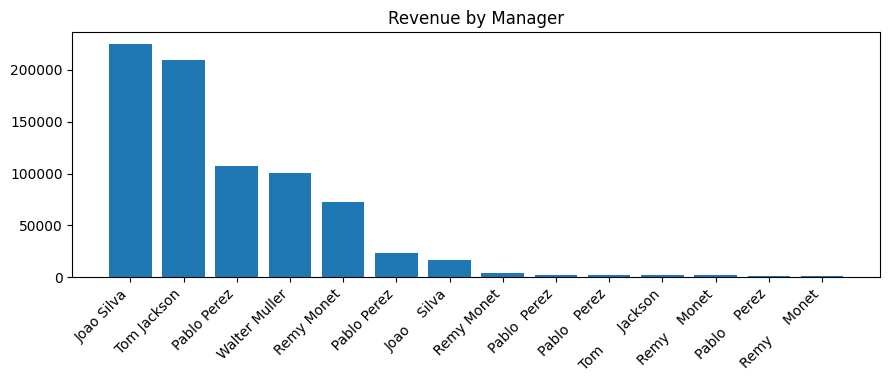

,Orders,AOV,Revenue
Manager,,,
Joao Silva,70,"3,215.35","225,074.77"
Tom Jackson,74,"2,827.04","209,201.03"
Pablo Perez,36,"2,988.90","107,600.25"
Walter Muller,30,"3,353.34","100,600.13"
Remy Monet,24,"3,033.34","72,800.27"
Pablo Perez,7,"3,314.29","23,200.03"
Joao Silva,5,"3,327.87","16,639.35"
Remy Monet,2,"2,000.01","4,000.03"
Pablo Perez,1,"2,199.99","2,199.99"


In [5]:

mgr_orders = df.groupby(['Manager','Order ID']).agg(order_rev=('Revenue','sum')).reset_index()
mgr_kpi = mgr_orders.groupby('Manager')['order_rev'].agg(['count','mean','sum']).rename(columns={'count':'Orders','mean':'AOV','sum':'Revenue'}).sort_values('Revenue', ascending=False)

plt.figure(figsize=(9,4)); 
plt.bar(mgr_kpi.index, mgr_kpi['Revenue'])
plt.title("Revenue by Manager"); plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

mgr_kpi.style.format({'AOV':'{:,.2f}','Revenue':'{:,.2f}'})



## 5. City Growth & Price/Volume Differences
**Method:** City × Month revenue lines; growth from first to last month; average price and quantity mix by city.


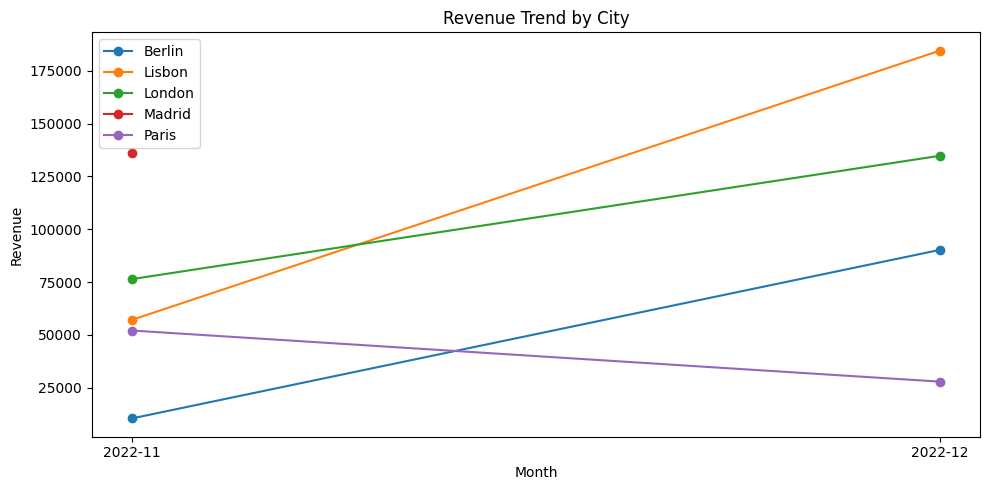

,Start_Month,End_Month,Growth_Rate
City,,,
Berlin,2022-11,2022-12,7.673035
Lisbon,2022-11,2022-12,2.232142
London,2022-11,2022-12,0.764402
Paris,2022-11,2022-12,-0.465384
Madrid,2022-11,2022-12,-1.000000


In [6]:

city_month = df.groupby(['City','month'])['Revenue'].sum().reset_index()

plt.figure(figsize=(10,5))
for city, sub in city_month.groupby('City'):
    sub = sub.sort_values('month')
    plt.plot(sub['month'].astype(str), sub['Revenue'].values, marker='o', label=city)
plt.title("Revenue Trend by City"); plt.xlabel("Month"); plt.ylabel("Revenue"); plt.legend(); plt.tight_layout(); plt.show()

pivot_cm = city_month.pivot(index='City', columns='month', values='Revenue').fillna(0)
months_avail = sorted(pivot_cm.columns.tolist())
growth = pd.DataFrame(index=pivot_cm.index)
if len(months_avail) >= 2:
    start, end = months_avail[0], months_avail[-1]
    growth['Start_Month'] = str(start)
    growth['End_Month']   = str(end)
    growth['Growth_Rate'] = (pivot_cm[end] - pivot_cm[start]) / pivot_cm[start].replace(0, np.nan)
growth.sort_values('Growth_Rate', ascending=False)



## 6. Basket & Cross-sell (Co-occurrence + Lift)
**Method:** Build order-level sets; compute co-occurrence counts and **lift**:  
Lift(f,s) = P(f & s) / (P(f)·P(s)) where probabilities over orders.


In [7]:

orders = df.groupby('Order ID')['Product'].apply(lambda s: set(s)).reset_index()
N = len(orders)
# Frequencies
freq = Counter()
for s in orders['Product']:
    for i in s:
        freq[i] += 1

# Co-occurrence
pair = Counter()
for s in orders['Product']:
    items = sorted(list(s))
    for i in range(len(items)):
        for j in range(i+1, len(items)):
            pair[(items[i], items[j])] += 1

rows = []
for (a,b), c in pair.items():
    pa = freq[a]/N; pb = freq[b]/N; pab = c/N
    lift = pab / (pa*pb) if pa*pb>0 else np.nan
    rows.append((a,b,c,lift))
lift_df = pd.DataFrame(rows, columns=['Item_A','Item_B','Cooccur_Orders','Lift']).sort_values('Lift', ascending=False)
lift_df.head(15)


,Item_A,Item_B,Cooccur_Orders,Lift



## 7. Price–Quantity Sensitivity (per Product)
**Method:** For each product with meaningful price variance, regress Quantity on Price (simple linear fit) and report slope & correlation.


In [8]:

sens_rows = []
for prod, sub in df.groupby('Product'):
    if sub['Price'].nunique() >= 3:
        x = sub['Price'].values
        y = sub['Quantity'].values
        # simple correlation and linear fit
        r = np.corrcoef(x, y)[0,1]
        slope, intercept = np.polyfit(x, y, 1)
        sens_rows.append((prod, slope, r, len(sub)))
sens = pd.DataFrame(sens_rows, columns=['Product','dQty/dPrice','Corr','N']).sort_values('Corr')
sens


,Product,dQty/dPrice,Corr,N


In [19]:
# Ensure Corr is numeric
sens['Corr'] = pd.to_numeric(sens['Corr'], errors='coerce')

# Visualize top 2 with most negative correlation (price up -> quantity down)
top2 = sens.nsmallest(2, 'Corr')
for _, row in top2.iterrows():
    prod = row['Product']
    subset = df[df['Product'] == prod]
    plt.scatter(subset['UnitPrice'], subset['Quantity'])
    plt.title(f"Price vs Quantity for {prod}\nCorr = {row['Corr']:.2f}")
    plt.xlabel("Unit Price")
    plt.ylabel("Quantity")
    plt.show()



## 8. Anomaly Detection — Daily Revenue (z-scores)
**Method:** Compute daily revenue, z-score, flag |z| ≥ 2.


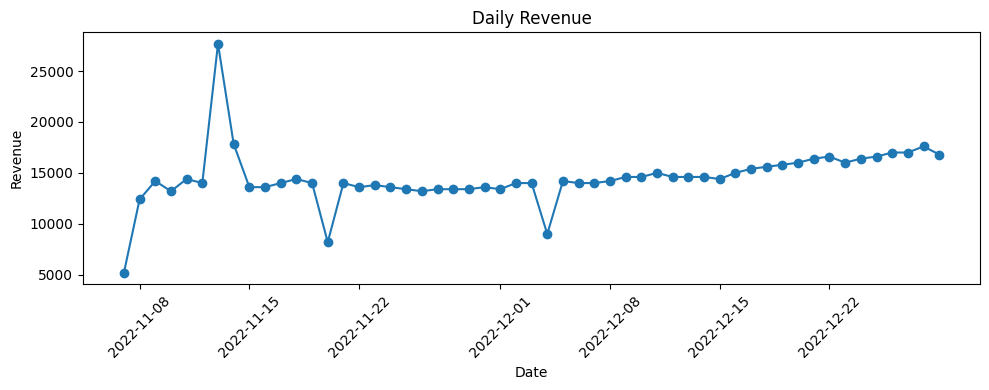

,Revenue
Date,
2022-11-07,5200.0023
2022-11-13,27674.4512
2022-11-20,8200.0466


In [20]:

daily = df.groupby(df['Date'].dt.date)['Revenue'].sum().sort_index()
z = (daily - daily.mean()) / daily.std(ddof=0)
anoms = daily[abs(z) >= 2]

plt.figure(figsize=(10,4))
plt.plot(daily.index, daily.values, marker='o')
plt.title("Daily Revenue"); plt.xlabel("Date"); plt.ylabel("Revenue"); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

anoms.to_frame(name='Revenue')



## 9. Order Value & Basket Size Distributions
**Method:** Group by `Order ID`; plot histograms and compute deciles.


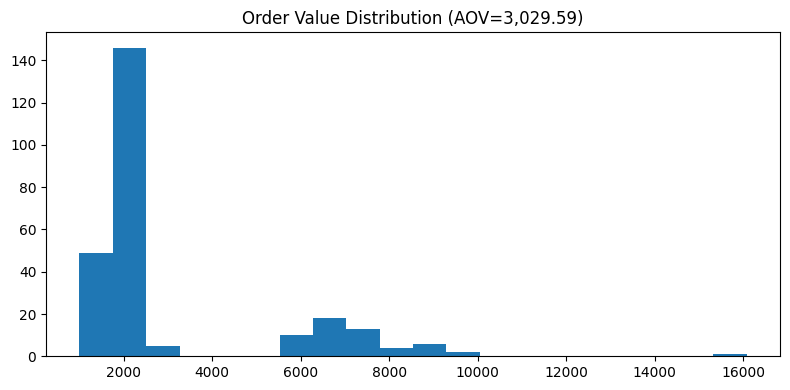

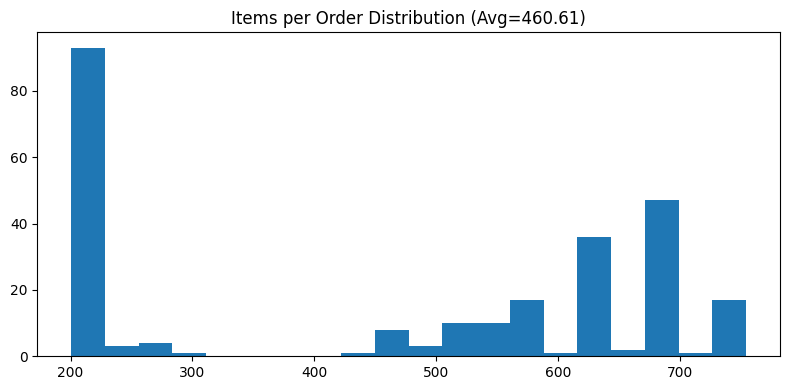

(     OrderRev_Quantile
 0.1          999.99600
 0.2         2000.01150
 0.3         2000.01150
 0.4         2000.04950
 0.5         2100.02040
 0.6         2199.99130
 0.7         2200.04450
 0.8         5999.95110
 0.9         7139.99247,
      Items_Quantile
 0.1         200.400
 0.2         201.010
 0.3         201.010
 0.4         449.578
 0.5         538.880
 0.6         630.370
 0.7         630.370
 0.8         677.970
 0.9         687.680)

In [21]:

orders_kpi = df.groupby('Order ID').agg(order_rev=('Revenue','sum'), items=('Quantity','sum'))
AOV = orders_kpi['order_rev'].mean()
items_avg = orders_kpi['items'].mean()

plt.figure(figsize=(8,4)); plt.hist(orders_kpi['order_rev'], bins=20); plt.title(f"Order Value Distribution (AOV={AOV:,.2f})"); plt.tight_layout(); plt.show()
plt.figure(figsize=(8,4)); plt.hist(orders_kpi['items'], bins=20); plt.title(f"Items per Order Distribution (Avg={items_avg:,.2f})"); plt.tight_layout(); plt.show()

deciles_rev = orders_kpi['order_rev'].quantile([i/10 for i in range(1,10)]).to_frame(name='OrderRev_Quantile')
deciles_items = orders_kpi['items'].quantile([i/10 for i in range(1,10)]).to_frame(name='Items_Quantile')
deciles_rev, deciles_items



## 10. Weekend Effect
**Method:** Compare average daily revenue on weekends vs weekdays.


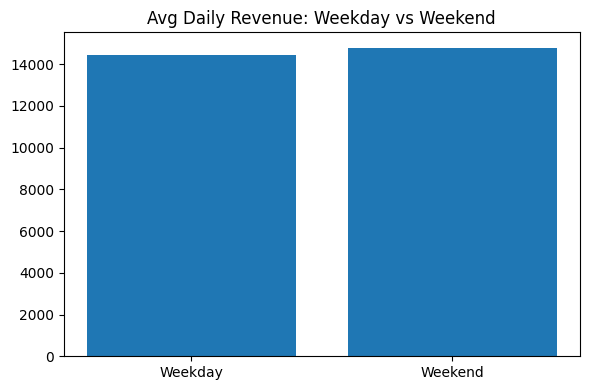

,AvgDailyRevenue
is_weekend,
Weekday,14421.560821
Weekend,14791.070514


In [22]:

df['is_weekend'] = df['dow'].isin(['Saturday','Sunday'])
daily_rev = df.groupby([df['Date'].dt.date, 'is_weekend'])['Revenue'].sum().reset_index()
wknd_avg = daily_rev.groupby('is_weekend')['Revenue'].mean().rename(index={False:'Weekday', True:'Weekend'})
plt.figure(figsize=(6,4)); plt.bar(wknd_avg.index.astype(str), wknd_avg.values); plt.title("Avg Daily Revenue: Weekday vs Weekend"); plt.tight_layout(); plt.show()
wknd_avg.to_frame(name='AvgDailyRevenue')



## 11. Summary — What to Act On
- **Mix shift:** Track which products gain share month-to-month; protect high-margin categories.
- **Pareto:** Focus on A-class products/cities for promotions and inventory priority.
- **Channel:** If online under-performs, optimize delivery ops or run app-only bundles.
- **Managers:** Replicate processes of top managers (AOV, order count).
- **Cities:** Double down on steep growth; fix declines with local promos/assortment.
- **Cross-sell:** Use high-lift pairs in bundles and suggestive selling UI.
- **Pricing:** Where price–quantity correlation is negative and significant, test smaller price moves.
- **Ops:** Watch anomaly days; align staffing with weekend effect and order-value distributions.
